## 3.4 Defining variability and smoothness with the covariance function

In [1]:
import torch
import gpytorch

from math import pi

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues_r"

from tqdm.notebook import tqdm

In [2]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def visualize_gp_belief(model, likelihood, num_samples=5):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

    plt.figure(figsize=(8, 6))

    plt.plot(xs, ys, label="objective", c="r")
    plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

    plt.plot(xs, predictive_mean, label="mean")
    plt.fill_between(
        xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
    )

    torch.manual_seed(0)
    for i in range(num_samples):
        plt.plot(xs, predictive_distribution.sample(), alpha=0.5, linewidth=2)

    plt.legend(fontsize=15)
    plt.show()

In [3]:
xs = torch.linspace(-3, 3, 101).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(0)
train_x = torch.rand(size=(3, 1)) * 6 - 3
train_y = forrester_1d(train_x)

### 3.4.1 Setting the scales of the covariance function

In [4]:
class ScaleGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

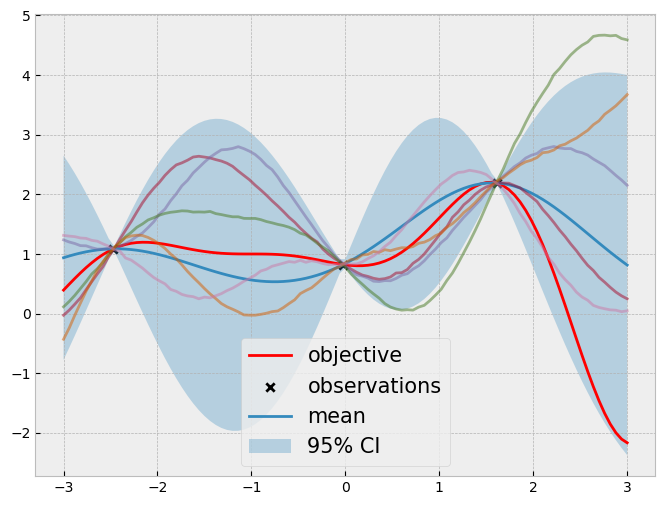

In [5]:
# declare the GP
lengthscale = 1  # 0.3, 1, 3
outputscale = 3  # 0.3, 1, 3
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ScaleGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

In [6]:
# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.covar_module.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

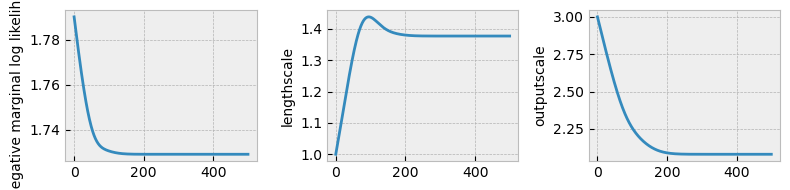

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(lengthscales)
ax[1].set_ylabel("lengthscale")

ax[2].plot(outputscales)
ax[2].set_ylabel("outputscale")

plt.tight_layout();

In [8]:
(
    model.covar_module.base_kernel.lengthscale.item(),
    model.covar_module.outputscale.item(),
)

(1.3772369623184204, 2.079803466796875)

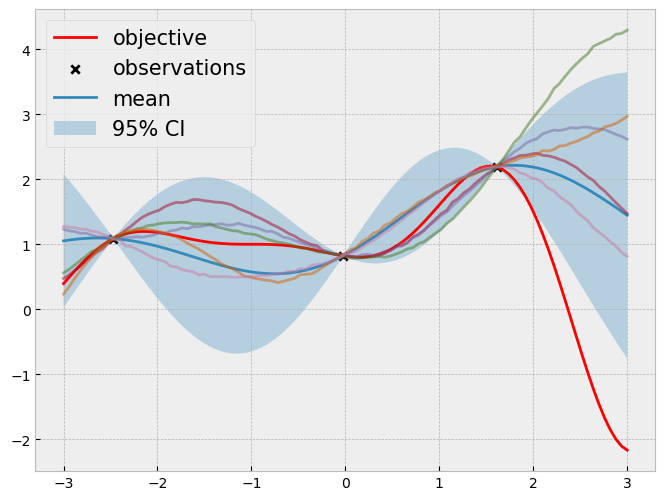

In [9]:
visualize_gp_belief(model, likelihood)

### 3.4.2 Controlling smoothness with different covariance functions

In [10]:
class RBFGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

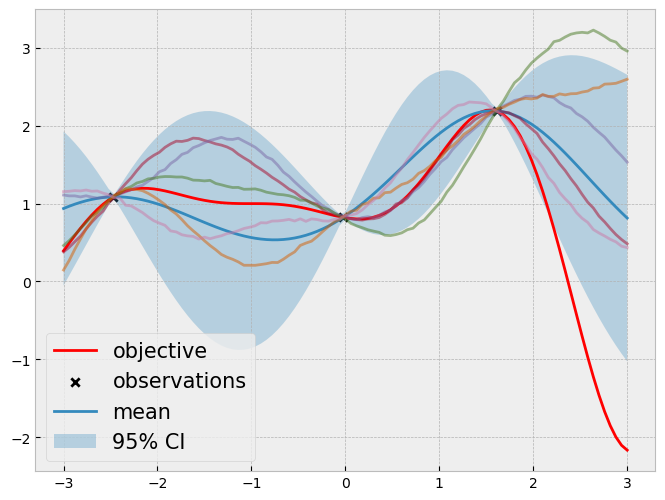

In [11]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RBFGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

In [12]:
class MaternGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, nu):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

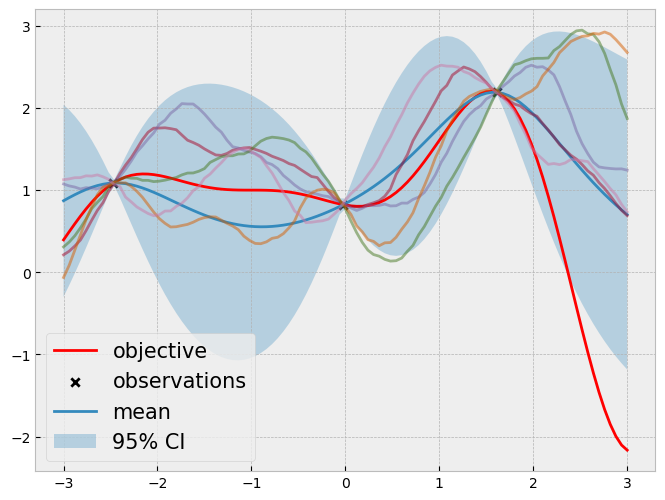

In [13]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MaternGPModel(train_x, train_y, likelihood, 2.5)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

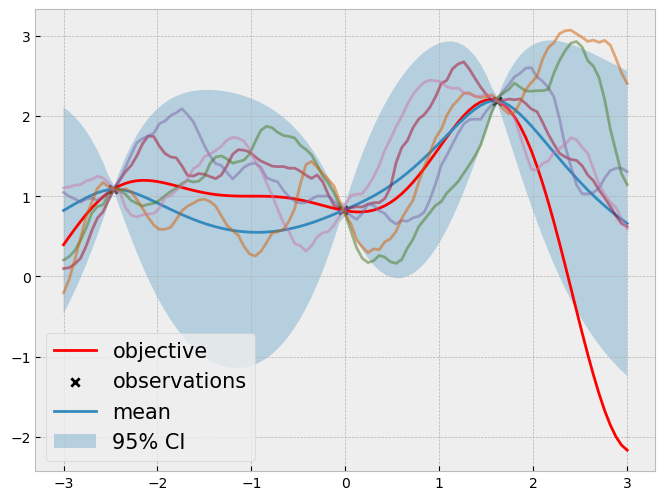

In [14]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MaternGPModel(train_x, train_y, likelihood, 1.5)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

### 3.4.3 Modeling different levels of variability with multiple length scales

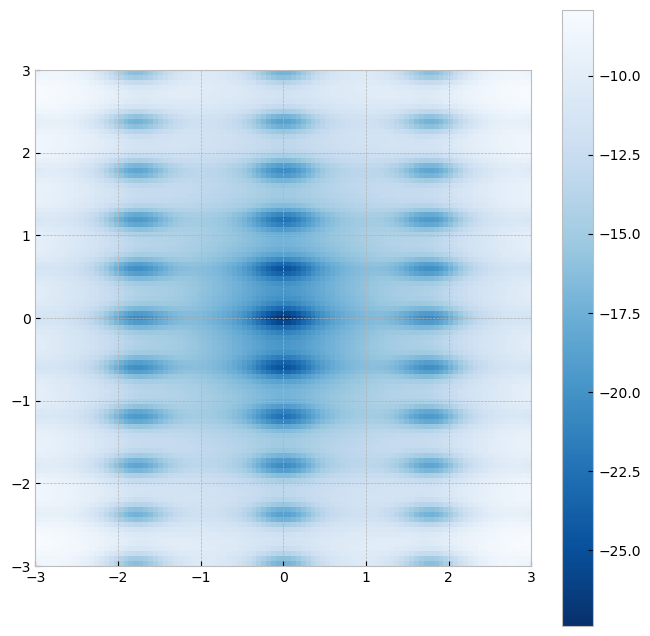

In [16]:
def ackley(x):
    # a modification of https://www.sfu.ca/~ssurjano/ackley.html
    return -20 * torch.exp(
        -0.2 * torch.sqrt((x[:, 0] ** 2 + x[:, 1] ** 2) / 2)
    ) - torch.exp(torch.cos(2 * pi * x[:, 0] / 3) + torch.cos(2 * pi * x[:, 1]))


xs = torch.linspace(-5, 5, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing="ij")
xs = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = ackley(xs)

plt.figure(figsize=(8, 8))

plt.imshow(ys.reshape(101, 101).T, origin="lower", extent=[-3, 3, -3, 3])
plt.colorbar();

In [17]:
torch.manual_seed(0)
train_x = torch.rand(size=(100, 2)) * 6 - 3
train_y = ackley(train_x)

In [18]:
class ARDGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
# declare the GP
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ARDGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.likelihood.noise = noise

# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
x_lengthscales = []
y_lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    x_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 0].item())
    y_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 1].item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

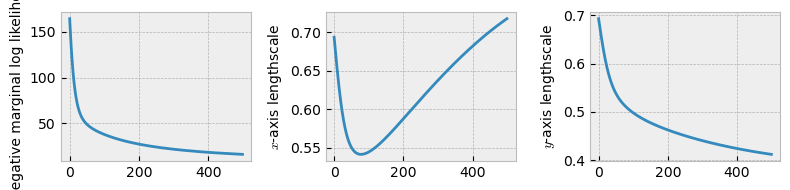

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(x_lengthscales)
ax[1].set_ylabel(r"$x$-axis lengthscale")

ax[2].plot(y_lengthscales)
ax[2].set_ylabel(r"$y$-axis lengthscale")

plt.tight_layout();

In [21]:
model.covar_module.base_kernel.lengthscale

tensor([[0.7175, 0.4117]], grad_fn=<SoftplusBackward0>)